In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env
from gym_trading_env.environments import dynamic_feature_last_position_taken

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationary_dgp, 
    make_ohlc,
    FeatureEngineering
)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

In [2]:
x0, mu_epsilon = 10, 100

N, window, stride = 100000, 24, 24  # simulation with ohlc
# N, window, stride = 10000, 1, 1  # simulation with tick data

x_c, y_c = stationary_dgp(N=N, x0=x0, mu=mu_epsilon)
y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c

df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

In [3]:
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
    row_heights=[0.33, 0.33, 0.34],
    subplot_titles=["Candlestick Chart: X", "Candlestick Chart: Y", "Candlestick Chart: Y - X"]
)

# Row 1: X candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=x_o,
    high=x_h,
    low=x_l,
    close=x_c,
    name="X"
), row=1, col=1)

# Row 2: Y candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=y_o,
    high=y_h,
    low=y_l,
    close=y_c,
    name="Y"
), row=2, col=1)

# Row 3: Y - X candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=spread_o,
    high=spread_h,
    low=spread_l,
    close=spread_c,
    name="Y - X"
), row=3, col=1)

# Layout adjustments
fig.update_layout(
    height=600,
    xaxis_rangeslider_visible=False,   # Row 1
    xaxis2_rangeslider_visible=False,  # Row 2
    xaxis3_rangeslider_visible=False,  # Row 3
    showlegend=False,
    margin=dict(t=40, b=20)
)

fig.show()

In [4]:
# confirm the x, y pair is cointegrated, such that spread is stationary
x_ols = sm.add_constant(x_c)
ols = sm.OLS(y_c, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.894e+06
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        22:57:28   Log-Likelihood:                 179.16
No. Observations:                4166   AIC:                            -354.3
Df Residuals:                    4164   BIC:                            -341.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.0048      0.004   2.52e+04      0.0

In [5]:
adfuller_test = adfuller(spread_c)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -20.17880249346918
p-value: 0.0
Is the spread stationary? Yes


In [6]:
feature_config = [
    {'type': 'rolling',
     'params': {
       'cols': ['close'],
       'window': 7,
       'mode': 'logdiff',
       'subtract_mean': False
     }},
]

df_train = df.copy()
fe = FeatureEngineering(df_train)
df_train = fe.build_features(feature_config)
df_train

,open,high,low,close,feature_close_lag_0,feature_close_lag_1,feature_close_lag_2,feature_close_lag_3,feature_close_lag_4,feature_close_lag_5,feature_close_lag_6
2020-01-01,99.976714,100.416287,99.553506,99.894133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,99.877169,100.159635,99.356040,99.798789,-0.000955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,99.932459,100.595866,99.656948,100.030798,0.002322,-0.000955,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-04,99.880340,100.594104,99.435459,100.150364,0.001195,0.002322,-0.000955,0.000000,0.000000,0.000000,0.000000
2020-01-05,100.135658,100.512620,99.533979,100.057700,-0.000926,0.001195,0.002322,-0.000955,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2031-05-24,99.985151,100.696686,99.688876,100.171665,0.001127,0.000309,-0.002413,0.003122,0.001161,0.001718,-0.008828
2031-05-25,100.203950,100.492262,99.606009,100.179968,0.000083,0.001127,0.000309,-0.002413,0.003122,0.001161,0.001718
2031-05-26,100.346258,100.613016,99.563979,99.806955,-0.003730,0.000083,0.001127,0.000309,-0.002413,0.003122,0.001161
2031-05-27,99.957312,100.432656,99.553385,99.878339,0.000715,-0.003730,0.000083,0.001127,0.000309,-0.002413,0.003122


In [7]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        # dynamic_feature_functions = [],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 0. 0. 0. 0. 0. 0. 1. 1.]
Market Return :  0.34%   |   Portfolio Return : -26.36%   |   Position Changes : 2719   |   Episode Length : 4166   |   


In [8]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions, target_net_layers=[8], policy_net_layers=[8])
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return :  0.34%   |   Portfolio Return : -54.84%   |   Position Changes : 2829   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : -70.63%   |   Position Changes : 3419   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 2794.96%   |   Position Changes : 2800   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 19172.08%   |   Position Changes : 2268   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 25579.57%   |   Position Changes : 2150   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 32349.46%   |   Position Changes : 2115   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 33196.81%   |   Position Changes : 2149   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 35515.20%   |   Position Changes : 2173   |   Episode Length : 4166   |   
Market Return :  0.34

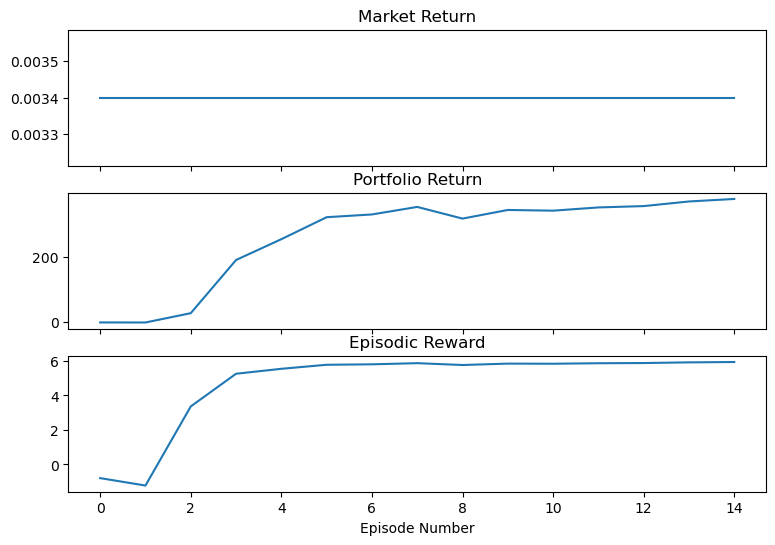

In [9]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

fig, axs = plt.subplots(3, 1, figsize=(9, 6), sharex=True)
axs[0].plot(all_metrics["Market Return"], label="Market Return")
axs[0].set_title("Market Return")
axs[1].plot(all_metrics["Portfolio Return"], label="Portfolio Return")
axs[1].set_title("Portfolio Return")
axs[2].plot(all_metrics["episodic_reward"], label="Episodic Reward")
axs[2].set_title("Episodic Reward")
axs[2].set_xlabel("Episode Number")
plt.show()

In [10]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x_c, y_c = stationary_dgp(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationary_dgp_qlearning",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            # dynamic_feature_functions = [],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.44%   |   Portfolio Return : 33561.23%   |   Position Changes : 1817   |   Episode Length : 4166   |   
Market Return : -0.04%   |   Portfolio Return : 35305.26%   |   Position Changes : 1831   |   Episode Length : 4166   |   
Market Return :  0.79%   |   Portfolio Return : 36977.26%   |   Position Changes : 1856   |   Episode Length : 4166   |   
Market Return : -0.21%   |   Portfolio Return : 36086.87%   |   Position Changes : 1858   |   Episode Length : 4166   |   
Market Return :  0.27%   |   Portfolio Return : 31581.63%   |   Position Changes : 1862   |   Episode Length : 4166   |   
Market Return : -0.12%   |   Portfolio Return : 34067.41%   |   Position Changes : 1870   |   Episode Length : 4166   |   
Market Return :  0.01%   |   Portfolio Return : 48458.84%   |   Position Changes : 1867   |   Episode Length : 4166   |   
Market Return : -0.03%   |   Portfolio Return : 38835.90%   |   Position Changes : 1853   |   Episode Length : 4166   |   
Market Return : 

In [11]:
# env_test.unwrapped.save_for_render(dir = "render_logs")

historical_info_df = pd.DataFrame(list(env_test.unwrapped.historical_info))
historical_info_df.columns

Index(['idx', 'step', 'date', 'position_index', 'position', 'real_position',
       'data_open', 'data_high', 'data_volume', 'data_close', 'data_low',
       'portfolio_valuation', 'portfolio_distribution_asset',
       'portfolio_distribution_fiat', 'portfolio_distribution_borrowed_asset',
       'portfolio_distribution_borrowed_fiat',
       'portfolio_distribution_interest_asset',
       'portfolio_distribution_interest_fiat', 'reward'],
      dtype='object')

In [12]:
def extract_signals(historical_info_df: pd.DataFrame):
    """
    Given a DataFrame with columns ['data_close', 'position'], 
    shift and detect only the entry/exit transitions.
    Returns (buy_df, sell_df, exit_df).
    """
    df = historical_info_df[['data_close', 'position']].copy()
    df['position'] = df['position'].shift(-1)
    df['prev_position'] = df['position'].shift(1)

    buy_df = df[(df['position'] == 1) & (df['prev_position'] != 1)]
    sell_df = df[(df['position'] == -1) & (df['prev_position'] != -1)]
    exit_df = df[(df['position'] == 0) & (df['prev_position'] != 0)]

    return buy_df, sell_df, exit_df


def build_fig(historical_info_df: pd.DataFrame,
              buy_df: pd.DataFrame,
              sell_df: pd.DataFrame,
              exit_df: pd.DataFrame):
    """
    Build a 2-row subplot:
     - Row 1: candlestick + buy/sell/exit markers
     - Row 2: portfolio valuation line
    Returns the Plotly Figure.
    """
    sample = historical_info_df
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        row_heights=[0.7, 0.3],
        subplot_titles=["Price Candlestick", "Portfolio Value"]
    )

    # Row 1: Candlestick
    fig.add_trace(go.Candlestick(
        x=sample.index,
        open=sample['data_open'],
        high=sample['data_high'],
        low=sample['data_low'],
        close=sample['data_close'],
        name="Price"
    ), row=1, col=1)

    # Markers
    marker_specs = {
        'Buy':    dict(df=buy_df,   color='green', symbol='triangle-up'),
        'Sell':   dict(df=sell_df,  color='red',   symbol='triangle-down'),
        'Exit':   dict(df=exit_df,  color='blue',  symbol='circle'),
    }
    for name, spec in marker_specs.items():
        fig.add_trace(go.Scatter(
            x=spec['df'].index,
            y=spec['df']['data_close'],
            mode='markers',
            marker=dict(color=spec['color'], size=10, symbol=spec['symbol']),
            name=name
        ), row=1, col=1)

    # Row 2: Portfolio value
    fig.add_trace(go.Scatter(
        x=sample.index,
        y=sample['portfolio_valuation'],
        mode='lines',
        line=dict(color='blue'),
        name="Portfolio Value"
    ), row=2, col=1)

    # Layout
    fig.update_layout(
        height=500,
        margin=dict(t=40, b=20, l=40, r=20),
        xaxis_rangeslider_visible=False,
        xaxis2_rangeslider_visible=False  # if you ever disable or have more subplots
    )
    return fig

In [13]:
buy_df_qlearning, sell_df_qlearning, exit_df_qlearning = extract_signals(historical_info_df)
fig_qlearning = build_fig(
    historical_info_df,
    buy_df_qlearning,
    sell_df_qlearning,
    exit_df_qlearning
)
fig_qlearning.show()

In [14]:
def plot_signals_distribution(signals_df, threshold):
    """
    Plots a violin + jittered stripplot of data_close by position,
    with a horizontal line at `threshold`.
    """
    plt.figure(figsize=(8, 6))
    # Violin (no inner box)
    sns.violinplot(
        data=signals_df,
        x='position',
        y='data_close',
        inner=None,
        color=".8"
    )
    # Jittered points
    sns.stripplot(
        data=signals_df,
        x='position',
        y='data_close',
        jitter=0.2,
        size=4,
        alpha=0.6
    )
    # Threshold line
    plt.axhline(threshold, color='r', linestyle='--', label=f'y = {threshold}')
    plt.legend()

    plt.title('Distribution + Jittered Points by Position')
    plt.tight_layout()
    plt.show()


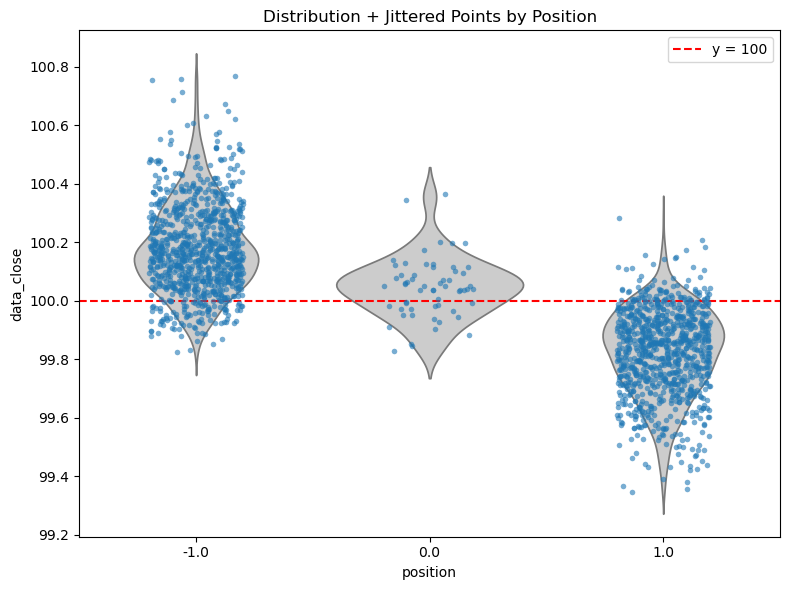

In [15]:
signals_df_qlearning = pd.concat([buy_df_qlearning, sell_df_qlearning, exit_df_qlearning])
plot_signals_distribution(signals_df_qlearning, threshold=mu_epsilon)

In [16]:
# build features
df_train = df.copy()

feature_config = [
    # {'type': 'rolling',
    #  'params': {
    #    'cols': ['close'],
    #    'window': 7,
    #    'mode': 'diff',
    #    'subtract_mean': False
    #  }},
    {'type': 'select',
     'params': {
         'cols': ['close'],
     }}
]

fe = FeatureEngineering(df_train)
fe.build_features(feature_config)
df_train = fe.df.copy()
df_train

,open,high,low,close,feature_close
2020-01-01,99.976714,100.416287,99.553506,99.894133,99.894133
2020-01-02,99.877169,100.159635,99.356040,99.798789,99.798789
2020-01-03,99.932459,100.595866,99.656948,100.030798,100.030798
2020-01-04,99.880340,100.594104,99.435459,100.150364,100.150364
2020-01-05,100.135658,100.512620,99.533979,100.057700,100.057700
...,...,...,...,...,...
2031-05-24,99.985151,100.696686,99.688876,100.171665,100.171665
2031-05-25,100.203950,100.492262,99.606009,100.179968,100.179968
2031-05-26,100.346258,100.613016,99.563979,99.806955,99.806955
2031-05-27,99.957312,100.432656,99.553385,99.878339,99.878339


In [17]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[99.894135 -1.       -1.      ]
Market Return :  0.34%   |   Portfolio Return : -0.34%   |   Position Changes : 0   |   Episode Length : 4166   |   


In [18]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return :  0.34%   |   Portfolio Return : -42.55%   |   Position Changes : 2789   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : -44.06%   |   Position Changes : 2786   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 1399.73%   |   Position Changes : 2821   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 1360.71%   |   Position Changes : 2740   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 12214.32%   |   Position Changes : 2557   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 11189.66%   |   Position Changes : 2549   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 30180.01%   |   Position Changes : 2366   |   Episode Length : 4166   |   
Market Return :  0.34%   |   Portfolio Return : 34259.59%   |   Position Changes : 2408   |   Episode Length : 4166   |   
Market Return :  0.34%

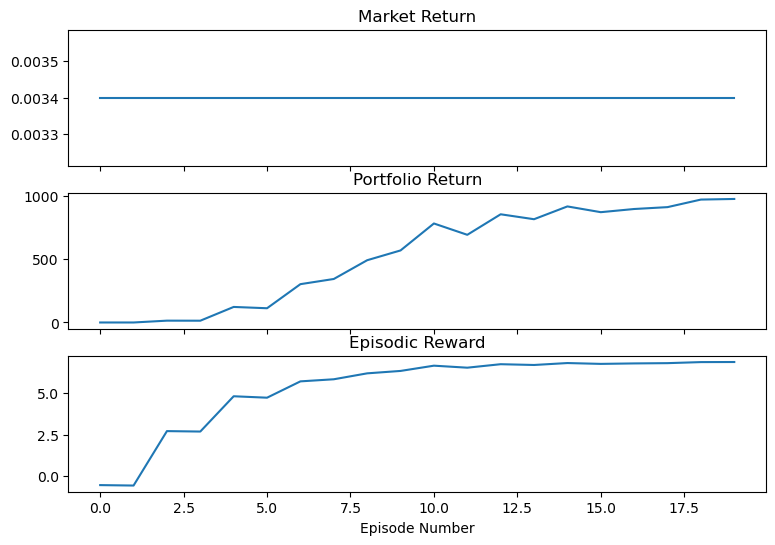

In [19]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

fig, axs = plt.subplots(3, 1, figsize=(9, 6), sharex=True)
axs[0].plot(all_metrics["Market Return"], label="Market Return")
axs[0].set_title("Market Return")
axs[1].plot(all_metrics["Portfolio Return"], label="Portfolio Return")
axs[1].set_title("Portfolio Return")
axs[2].plot(all_metrics["episodic_reward"], label="Episodic Reward")
axs[2].set_title("Episodic Reward")
axs[2].set_xlabel("Episode Number")
plt.show()

In [20]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x_c, y_c = stationary_dgp(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
    fe = FeatureEngineering(_df)
    fe.build_features(feature_config)
    _df = fe.df.copy()

    env_test = gym.make("TradingEnv",
            name= "stationary_dgp_xgboost",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
            # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.44%   |   Portfolio Return : 55762.76%   |   Position Changes : 1862   |   Episode Length : 4166   |   
Market Return : -0.04%   |   Portfolio Return : 59409.28%   |   Position Changes : 1892   |   Episode Length : 4166   |   
Market Return :  0.79%   |   Portfolio Return : 50507.86%   |   Position Changes : 1865   |   Episode Length : 4166   |   
Market Return : -0.21%   |   Portfolio Return : 59244.77%   |   Position Changes : 1895   |   Episode Length : 4166   |   
Market Return :  0.27%   |   Portfolio Return : 56940.93%   |   Position Changes : 1935   |   Episode Length : 4166   |   
Market Return : -0.12%   |   Portfolio Return : 54830.97%   |   Position Changes : 1867   |   Episode Length : 4166   |   
Market Return :  0.01%   |   Portfolio Return : 92143.81%   |   Position Changes : 1958   |   Episode Length : 4166   |   
Market Return : -0.03%   |   Portfolio Return : 64403.16%   |   Position Changes : 1930   |   Episode Length : 4166   |   
Market Return : 

In [21]:
# env_test.unwrapped.save_for_render(dir = "render_logs")

historical_info_df = pd.DataFrame(list(env_test.unwrapped.historical_info))

In [22]:
buy_df_xgb, sell_df_xgb, exit_df_xgb = extract_signals(historical_info_df)
fig_xgb = build_fig(
    historical_info_df,
    buy_df_xgb,
    sell_df_xgb,
    exit_df_xgb
)
fig_xgb.show()

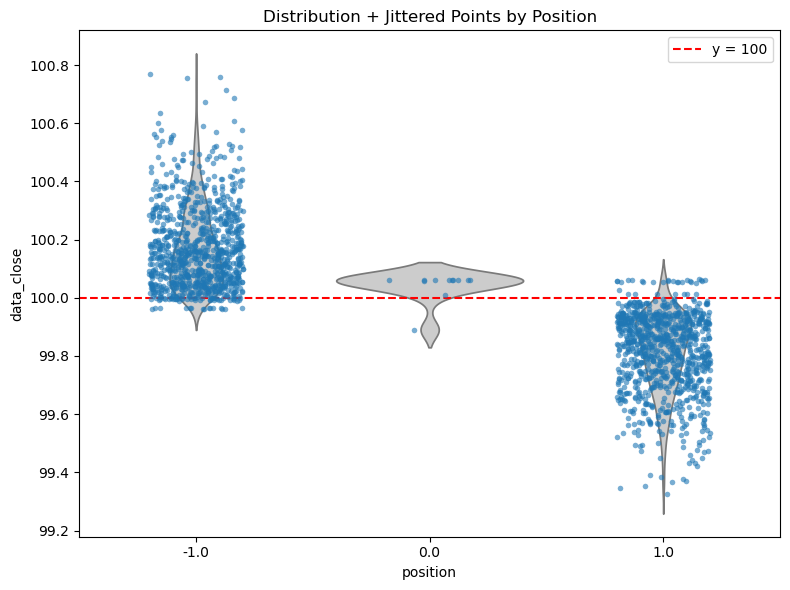

In [23]:
signals_df_xgb = pd.concat([buy_df_xgb, sell_df_xgb, exit_df_xgb])
plot_signals_distribution(signals_df_xgb, threshold=mu_epsilon)

In [24]:
len(signals_df_qlearning), len(signals_df_xgb)

(1891, 1921)

In [25]:
signals_df_qlearning["above"] = signals_df_qlearning["data_close"] > 100
signals_df_qlearning.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: '≤ 100', True: '> 100'})

above,≤ 100,> 100
position,,
-1.0,100,827
0.0,20,39
1.0,820,85


In [26]:
signals_df_xgb["above"] = signals_df_xgb["data_close"] > 100
signals_df_xgb.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: '≤ 100', True: '> 100'})

above,≤ 100,> 100
position,,
-1.0,51,901
0.0,1,11
1.0,926,31
